# Farfetch case study

## Product category classification

* Author: Kai Chen
* Date: Apr, 2018

In [2]:
import pandas as pd
import numpy as np
import os
import sys
import itertools
import operator
from random import shuffle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras import callbacks, applications, optimizers

np.random.seed(42)

In [3]:
# ---------------------
# Define the file paths

PRODUCT_CSV_FILE = 'data/products.csv'
ATTRIBUTE_CSV_FILE = 'data/attributes.csv'

## Step 1: read and explore the data

In [7]:
df_product = pd.read_csv(PRODUCT_CSV_FILE)

display(df_product.head())
print(df_product.shape)

list_product_id = df_product['ProductId'].unique()
list_product_id = np.array(list_product_id)
print('number of products {}'.format(list_product_id.shape[0]))

,ProductId,Description,DescriptionDate,SeasonOriginal,ProductName,Brand,Gender,Colour,Family,Category,ArticlePhotoId,CreateDate
0,11295277,VIPE6CE-169953MCC 38NO,2016-01-07 13:13:09.527,SS15,Celine Black Phantom Bag,CELINE COLLARD,WOMEN,BLACK,Bags,Tote Bags,6129459,2016-01-07 13:10:46.507
1,11292059,Grey cotton 'Skip' crewneck from S.N.S. Herni...,2016-01-08 14:45:59.673,SS16,'Skip' crewneck,S.N.S. HERNING,MEN,GREY,Clothing,Sweaters & Knitwear,6156126,2016-01-04 19:52:05.203
2,11290981,Multicolour cotton 'Pak’r Tatenda' backpack fr...,2016-01-11 19:27:45.330,SS16,'Pakr Tatenda' backpack,EASTPAK,UNISEX,YELLOW & ORANGE,Bags,Backpacks,6216609,2016-01-03 15:21:20.480
3,11293179,Ivory white and black hemp-cotton blend 'Honey...,2016-01-13 11:33:11.150,SS16,'Honey' wide brim hat,EUGENIA KIM,WOMEN,WHITE,Accessories,Hats,6199465,2016-01-05 18:08:57.317
4,11293099,Ivory white cotton embroidered lace frilled dr...,2016-01-13 15:22:08.247,SS16,embroidered lace frilled dress,RED VALENTINO,WOMEN,WHITE,Clothing,Dresses,6173011,2016-01-05 16:55:35.427


(12631, 12)
number of products 12631


In [9]:
list_category = df_product['Category'].unique()
list_category = np.array(list_category)

display(df_product['Category'])
print('number of category {}'.format(list_category.shape[0]))

0                         Tote Bags
1               Sweaters & Knitwear
2                         Backpacks
3                              Hats
4                           Dresses
5                           Jackets
6                          Knitwear
7                          Trousers
8                             Denim
9                   Ballerina Shoes
10                          Sandals
11                 T-Shirts & Vests
12                      Clutch Bags
13                             Tops
14                          Dresses
15                         Trainers
16                          Jackets
17                             Tops
18                          Dresses
19                             Hats
20                      Clutch Bags
21                          Sandals
22                             Tops
23                         Trousers
24                             Tops
25                             Tops
26                        Tote Bags
27                        To

number of category 134


In [12]:
# Create a dictionary with key: product id -> value: category
# Note in this csv file we can find that each product belongs to only one category

dict_product_cat = dict()
for product_id in list_product_id:
    category = df_product[df_product['ProductId'] == product_id]['Category'].values
    if (len(category)) > 1:
         print('product {} belongs to more than two categories.'.format(product_id))
    dict_product_cat[product_id] = category[0]
    
display(dict_product_cat)

{11295277: 'Tote Bags',
 11292059: 'Sweaters & Knitwear',
 11290981: 'Backpacks',
 11293179: 'Hats',
 11293099: 'Dresses',
 11292510: 'Jackets',
 11292270: 'Knitwear',
 11294769: 'Trousers',
 11290777: 'Denim',
 11075939: 'Ballerina Shoes',
 11296157: 'Sandals',
 11290970: 'T-Shirts & Vests',
 11299949: 'Clutch Bags',
 11292683: 'Tops',
 11292576: 'Dresses',
 11295498: 'Trainers',
 11295793: 'Jackets',
 11291391: 'Tops',
 11294506: 'Dresses',
 11294667: 'Hats',
 11293411: 'Clutch Bags',
 11290726: 'Sandals',
 11297793: 'Tops',
 11294511: 'Trousers',
 11296986: 'Tops',
 11295393: 'Tops',
 11291782: 'Tote Bags',
 11293662: 'Tote Bags',
 11294564: 'Shorts',
 11296702: 'N/D',
 11294057: 'Trousers',
 11297350: 'Wallets & Cardholders',
 11294584: 'Knitwear',
 11293967: 'Trousers',
 11298122: 'Trainers',
 11256262: 'Clutch Bags',
 11289185: 'Tops',
 11293253: 'Dresses',
 11292021: 'Tops',
 11293634: 'Tops',
 11293639: 'Tops',
 11293561: 'Jackets',
 11295016: 'Trousers',
 11293293: 'Hats',
 11

In [13]:
# Create a dictionary with key: category -> value: a list of product id
dict_cat = dict()
dict_cat_nb_products = dict()
nb_products_cat = []
for category in list_category:
    products = df_product[df_product['Category'] == category]['ProductId'].values
    dict_cat[category] = products
    dict_cat_nb_products[category] = len(products)
    nb_products_cat.append(len(products))
    print('category {}  number of products {}'.format(category, len(products)))


category Tote Bags  number of products 341
category Sweaters & Knitwear  number of products 529
category Backpacks  number of products 101
category Hats  number of products 149
category Dresses  number of products 1022
category Jackets  number of products 904
category Knitwear  number of products 523
category Trousers  number of products 836
category Denim  number of products 270
category Ballerina Shoes  number of products 48
category Sandals  number of products 308
category T-Shirts & Vests  number of products 443
category Clutch Bags  number of products 164
category Tops  number of products 1539
category Trainers  number of products 501
category Shorts  number of products 177
category N/D  number of products 35
category Wallets & Cardholders  number of products 84
category Shoulder Bags  number of products 252
category Boots  number of products 265
category Skirts  number of products 333
category Phone, Computer & Gadgets  number of products 30
category Pumps  number of products 139

plot number of products per category


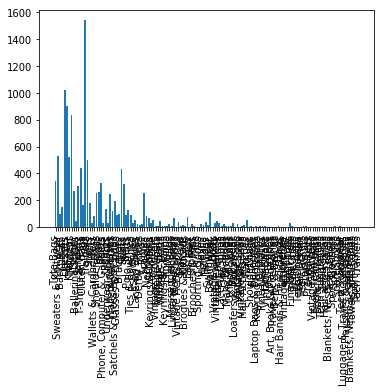

In [14]:
# Show number of products per category
print('plot number of products per category')
plt.bar(range(len(dict_cat_nb_products)), list(dict_cat_nb_products.values()), align='center')
plt.xticks(range(len(dict_cat_nb_products)), list(dict_cat_nb_products.keys()))
plt.xticks(rotation=90)
# # for python 2.x:
# plt.bar(range(len(dict_cat_nb_products)), dict_cat_nb_products.values(), align='center')  # python 2.x
# plt.xticks(range(len(dict_cat_nb_products)), dict_cat_nb_products.keys())  # in python 2.x
plt.show()
    

In [18]:
# Get max and min number of products per category
min_products = sys.maxsize
min_products_cat = ''
max_products = 0
max_products_cat = ''
for category, nb_products in dict_cat_nb_products.items():
    if nb_products < min_products:
        min_products = nb_products
        min_products_cat = category
    if nb_products > max_products:
        max_products = nb_products
        max_products_cat = category

print('category {} has the max number of products, i.e., {}'.format(max_products_cat, max_products))
print('category {} has the min number of products, i.e., {}'.format(min_products_cat, min_products))
print('mean number of products per category: {}'.format(round(np.mean(nb_products_cat), 2)))
print('standard deviation of number of products per category: {}'.format(round(np.std(nb_products_cat), 2)))


category Tops has the max number of products, i.e., 1539
category Ties has the min number of products, i.e., 1
mean number of products per category: 94.26
standard deviation of number of products per category: 211.19


In [19]:
# Create a dictionary with key: photo id -> value: product id
# Note one photo belongs only to one product
list_photo_id = df_product['ArticlePhotoId'].unique()
dict_photo_product_id = dict()
for photo_id in list_photo_id:
    dict_photo_product_id[photo_id] = df_product[df_product['ArticlePhotoId']==photo_id]['ProductId'].values[0]


## Step 2: Prepare train, test sets

In [20]:
percentage_train_set = 0.7

shuffle(list_product_id)

list_product_id_train = list_product_id[0:int(percentage_train_set*len(list_product_id))]
list_product_id_test = list_product_id[len(list_product_id_train):]

print('number of samples {}'.format(len(list_product_id)))
print('number of trainig samples {}'.format(len(list_product_id_train)))
print('number of trainig samples {}'.format(len(list_product_id_test)))


number of samples 12631
number of trainig samples 8841
number of trainig samples 3790


## Step 3: Train a CNN model for category classification

#### References
- https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
- https://machinelearningmastery.com/image-augmentation-deep-learning-keras/
- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- https://github.com/tatsuyah/CNN-Image-Classifier/blob/master/src/train-multiclass.py
- https://www.kaggle.com/fujisan/use-keras-pre-trained-vgg16-acc-98


In [33]:
class_names = list_category

# Note due to computation cost images are resized to smaller sizes
img_width, img_height = 80, 80

train_img_x = []
train_img_y = []
test_img_x = []
test_img_y = []

In [34]:
# ------------
# Get training and test images

img_dir_path = "data/images_{}_{}/".format(img_width, img_height)
dirs = os.listdir(img_dir_path)

# key: product id, value: image path
dict_img_path = dict()

for file_name in dirs:
    file_path = os.path.join(img_dir_path, file_name)

    img = load_img(file_path)         # this is a PIL image
    x = img_to_array(img)             # this is a Numpy array with shape (img_width, img_height, 3)
    # x = x.reshape((1,) + x.shape)   # this is a Numpy array with shape (1, 3, img_width, img_height)

    product_id = int(file_name.split('_')[0])

    dict_img_path[product_id] = file_path

    if not product_id in list_product_id:
        print('photo {} does not have product information'.format(file_path))

    if product_id in list_product_id:
        if product_id in list_product_id_train:
            train_img_x.append(x)
            train_img_y.append(dict_product_cat[product_id])
        elif product_id in list_product_id_test:
            test_img_x.append(x)
            test_img_y.append(dict_product_cat[product_id])

train_img_x = np.array(train_img_x)
train_img_y = np.array(train_img_y)
test_img_x = np.array(test_img_x)
test_img_y = np.array(test_img_y)

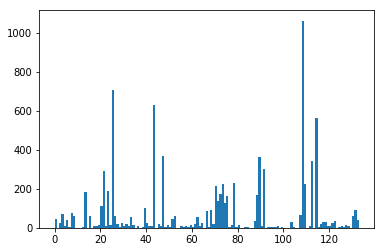

In [35]:
# ----------
# Transform category to one-hot encoding

le = preprocessing.LabelEncoder()
le.fit(class_names)
train_img_y = le.transform(train_img_y)
test_img_y = le.transform(test_img_y)

plt.hist(train_img_y.tolist(), range(min(train_img_y), max(train_img_y)+1))
plt.show()

In [36]:
train_img_y = to_categorical(train_img_y, num_classes = len(class_names))
test_img_y = to_categorical(test_img_y, num_classes = len(class_names))

# Split the train and the validation set for the fitting
train_img_x, val_img_x, train_img_y, val_img_y = train_test_split(train_img_x, train_img_y, test_size = 0.1, random_state=42)

print('train set shape')
print(np.array(train_img_x).shape)
print('validation set shape')
print(np.array(val_img_x).shape)

train set shape
(7830, 80, 80, 3)
validation set shape
(871, 80, 80, 3)


In [38]:
# ----------------------
# CNN hyperparameters

epochs = 20
batch_size = 32
filters = [16, 16, 8, 8]
kernel_sizes = [11, 11, 7, 7]
strides = [2, 2, 2, 2]
pooling_sizes = [2, 2]

str_parameters = '[epochs]{}-[batch_size]{}-[filters]{}-[kernel_sizes]{}-[strides]{}-[pooling_sizes]{}'.format(epochs,
                                                                                                                batch_size,
                                                                                                                '_'.join(str(x) for x in filters),
                                                                                                                '_'.join(str(x) for x in kernel_sizes),
                                                                                                                '_'.join(str(x) for x in strides),
                                                                                                                '_'.join(str(x) for x in pooling_sizes),
                                                                                                                )

model_name = 'CNN'
#model_name = 'VGG16'  # require GPU 


In [43]:
# ----------------
# Define the CNN models

model = None
if model_name == 'CNN':
    model = Sequential()

    model.add(Conv2D(filters = filters[0], kernel_size = (kernel_sizes[0], kernel_sizes[0]),
                     padding = 'Same', strides=strides[0],  input_shape = (img_width, img_height, 3)),
                     #activation ='relu',
                    )
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(filters = filters[1], kernel_size = (kernel_sizes[1], kernel_sizes[1]),
                     padding = 'Same', strides=strides[1],
                     #activation ='relu'
                     ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPool2D(pool_size=(pooling_sizes[0], pooling_sizes[0])))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters = filters[2], kernel_size = (kernel_sizes[2], kernel_sizes[2]),
                     padding = 'Same', strides=strides[2],
                     #activation ='relu'
                     ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(filters = filters[3], kernel_size = (kernel_sizes[3], kernel_sizes[3]),
                     padding = 'Same', strides=strides[3],
                     #activation ='relu'
                     ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPool2D(pool_size=(pooling_sizes[1], pooling_sizes[1])))
    model.add(Dropout(0.2))

    model.add(Flatten())
    #model.add(Dense(256, activation = "relu"))
    model.add(Dense(256, kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(len(class_names), activation = "softmax"))

elif model_name == 'VGG16':
    # use pre-trained VGG16
    base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

    add_model = Sequential()
    add_model.add(Flatten(input_shape=base_model.output_shape[1:]))

    add_model.add(Dense(256, kernel_initializer='glorot_uniform'))
    # add_model.add(Dense(1, activation='sigmoid'))
    add_model.add(BatchNormalization())
    add_model.add(Activation('relu'))
    add_model.add(Dropout(0.2))

    add_model.add(Dense(len(class_names), activation="softmax"))

    model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

    # model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
    #              metrics=['accuracy'])

print(model.summary())

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
#optimizer = optimizers.SGD(lr=1e-3, momentum=0.9) 

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 40, 40, 16)        5824      
_________________________________________________________________
batch_normalization_6 (Batch (None, 40, 40, 16)        64        
_________________________________________________________________
activation_6 (Activation)    (None, 40, 40, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 20, 16)        30992     
_________________________________________________________________
batch_normalization_7 (Batch (None, 20, 20, 16)        64        
_________________________________________________________________
activation_7 (Activation)    (None, 20, 20, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 16)        0         
__________

In [44]:
# -----------
# Data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,               # set input mean to 0 over the dataset
        samplewise_center=False,                # set each sample mean to 0
        featurewise_std_normalization=False,    # divide inputs by std of the dataset
        samplewise_std_normalization=False,     # divide each input by its std
        zca_whitening=False,                    # apply ZCA whitening
        rotation_range=10,                      # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                       # randomly zoom image
        width_shift_range=0.1,                  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,                 # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,                  # randomly flip images
        vertical_flip=False)                    # randomly flip images

datagen.fit(train_img_x)

Epoch 1/20
 - 46s - loss: 3.3367 - acc: 0.1891 - val_loss: 7.2349 - val_acc: 0.1332
Epoch 2/20
 - 46s - loss: 2.8931 - acc: 0.2646 - val_loss: 8.5901 - val_acc: 0.1412
Epoch 3/20
 - 46s - loss: 2.7965 - acc: 0.2876 - val_loss: 2.9343 - val_acc: 0.2997
Epoch 4/20
 - 46s - loss: 2.6941 - acc: 0.3082 - val_loss: 2.5657 - val_acc: 0.3134
Epoch 5/20
 - 46s - loss: 2.6457 - acc: 0.3135 - val_loss: 2.6387 - val_acc: 0.3525
Epoch 6/20
 - 46s - loss: 2.5954 - acc: 0.3178 - val_loss: 2.5098 - val_acc: 0.3777
Epoch 7/20
 - 44s - loss: 2.5844 - acc: 0.3367 - val_loss: 2.4392 - val_acc: 0.3972
Epoch 8/20
 - 46s - loss: 2.5144 - acc: 0.3390 - val_loss: 2.4375 - val_acc: 0.3961
Epoch 9/20
 - 45s - loss: 2.5104 - acc: 0.3473 - val_loss: 2.5374 - val_acc: 0.3766
Epoch 10/20
 - 44s - loss: 2.4883 - acc: 0.3468 - val_loss: 2.4348 - val_acc: 0.3789

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 11/20
 - 48s - loss: 2.4581 - acc: 0.3624 - val_loss: 2.2396 - val_acc: 

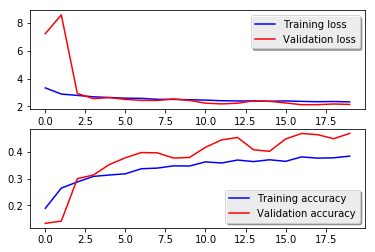

In [45]:
# -------------
# Train the CNN model
history = model.fit_generator(datagen.flow(train_img_x, train_img_y, batch_size=batch_size),
                              epochs = epochs, validation_data = (val_img_x, val_img_y),
                              verbose = 2, steps_per_epoch=train_img_x.shape[0] // batch_size, callbacks=[learning_rate_reduction])


# Training and validation curves
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


plt.show()

In [ ]:
# Save the model
model_dir = './models/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

model_path = ''
if model_name == 'CNN':
    model_path = '{}cat-cnn-model-{}.h5'.format(model_dir, str_parameters)
elif model_name == 'VGG16':
    model_path = '{}cat-vgg16-{}-{}.h5'.format(model_dir, epochs, batch_size)
model.save(model_path)
print('save model to {}'.format(model_path))

model_weights_path = ''
if model_name == 'CNN':
    model_weights_path = '{}cat-cnn-weights-{}.h5'.format(model_dir, str_parameters)
elif model_name == 'VGG16':
    model_weights_path = '{}cat-vgg16-weights-{}-{}.h5'.format(model_dir, epochs, batch_size)
model.save_weights(model_weights_path)
print('save weights to {}'.format(model_weights_path))


## Step 4: Make predictions

In [ ]:
model = load_model(model_path)
model.load_weights(model_weights_path)

test_pred = model.predict(test_img_x)

## Step 5: Evaluation

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [ ]:
# convert predictions classes to one hot vectors
test_pred_classes = np.argmax(test_pred, axis = 1)
# results = pd.Series(test_pred_classes, name="Label")

# convert test observations to one hot vectors
test_true_classes = np.argmax(test_img_y, axis = 1)

# compute the confusion matrix
test_true_classes = le.inverse_transform(test_true_classes)
test_pred_classes = le.inverse_transform(test_pred_classes)

display(classification_report(test_true_classes, test_pred_classes, target_names=class_names))

confusion_mtx = confusion_matrix(test_true_classes, test_pred_classes)
display(confusion_mtx)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

plt.show()

In [ ]:
# ----------
# Display some error results

test_true_classes = np.array(test_true_classes).reshape((test_img_x.shape[0], 1))
test_pred_classes = np.array(test_pred_classes).reshape((test_img_x.shape[0], 1))

error_indices = []
for i, val in enumerate(test_true_classes):
    if test_true_classes[i][0] != test_pred_classes[i][0]:
        error_indices.append(i)

list_error_product_id = []
for i in error_indices:
    list_error_product_id.append(list_product_id_test[i])

print('error classified products')
print(list_error_product_id)

acc = 1 - len(list_error_product_id) / len(list_product_id_test)
print('accuracy {}'.format(acc))

index = 0
img = mpimg.imread(dict_img_path[list_error_product_id[index]])
imgplot = plt.imshow(img)
plt.title('[ProductID]{} [Category]{} [Prediction]{}'.format(list_error_product_id[index], test_true_classes[index], test_pred_classes[index]))

plt.show()

## Future work

- Transfer learning
- Data augmentation
- Combine vision and text information